<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://segment-anything.com/demo#">Segment Anything avec Keras</a></div>
     </th>
</table>

<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://arxiv.org/pdf/2408.00714"><img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/sam2.png" width="1024"></a></div>

<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://github.com/facebookresearch/segment-anything"><img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/sam.png" width="1024"></a></div> 

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [2]:
import keras, keras_cv, pandas as pd, numpy as np, seaborn as sns, warnings
from keras import layers
from keras import ops
from PIL import Image
import math
from copy import deepcopy
from itertools import product
import cv2

import matplotlib.pyplot as plt
import matplotlib.colors
import tensorflow as tf
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.python.ops.numpy_ops import np_config
from keras_cv.src.layers.object_detection.non_max_suppression import non_max_suppression
from keras_cv.models import SegmentAnythingModel
from sam_keras import SAMPredictor

warnings.filterwarnings(action="ignore")


if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [4]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


In [5]:
! nvidia-smi

/bin/bash: /home/razvan/anaconda3/envs/keras3/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Jul  9 15:49:20 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
| 30%   54C    P3              81W / 350W |   2386MiB / 24576MiB |     54%      D

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [6]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

Le système est initialisé avec 1 GPUs


I0000 00:00:1752068960.911117 3282762 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752068960.932581 3282762 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752068960.932718 3282762 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752068960.939389 3282762 service.cc:146] XLA service 0xd4882d0 initialized for platform

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du modèle</div></b>

In [7]:
with strategy.scope():
    sam = SegmentAnythingModel.from_preset("sam_base_sa1b")
    model = SAMPredictor(sam)
    transform  = model.transform

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
        
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image, alpha = 0.8)
    
def show_mask_class(mask, ax, label=1, alpha = 0.4):
    couleur={0: '#ffffff', 1: '#be1229', 2: '#113d14', 3: '#752973'}
    color = np.array(list(matplotlib.colors.to_rgb(couleur[label]))+[alpha]).reshape(1, 1, -1)
        
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color
    ax.imshow(mask_image)    

def show_mask_all(mask, ax, label=1, alpha = 0.4):
    couleur={0: '#ffffff', 1: '#be1229', 2: '#113d14', 3: '#752973'}
    color = np.array(list(matplotlib.colors.to_rgb(couleur[label]))+[alpha]).reshape(1, 1, -1)
        
    mask_image = mask * color
    ax.imshow(mask_image)   

def show_points(coords, labels, ax, marker_size=375):
    hem_points = coords[labels == 1]
    sch_points = coords[labels == 2]
    ama_points = coords[labels == 3]
    
    ax.scatter(hem_points[:, 0], hem_points[:, 1], color='#be1229', marker='o', s=marker_size, edgecolor='white', linewidth=2, alpha = 0.8)
    ax.scatter(sch_points[:, 0], sch_points[:, 1], color='#113d14', marker='o', s=marker_size, edgecolor='white', linewidth=2, alpha = 0.8)
    ax.scatter(ama_points[:, 0], ama_points[:, 1], color='#752973', marker='o', s=marker_size, edgecolor='white', linewidth=2, alpha = 0.8)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# Detection avec les points

In [9]:
def afficheSegmentation(nom,model,strategy,nouvelleTaille=1024):
    tailleImageFichier,tailleImage=512,512 
    image=f'../donnees/{nom}.png'
    labels=f'../donnees/{nom}.parquet'
    image=tf.stack([tf.image.resize(tf.image.decode_jpeg(tf.stack(tf.io.read_file(image))),(tailleImage,tailleImage))]) 
    donnees=pd.read_parquet(labels)
    donnees.loc[:,['x_min', 'y_min', 'x_max', 'y_max']] *= tailleImage/tailleImageFichier
    donnees['x'] = donnees.x_min + (donnees.x_max - donnees.x_min)/2
    donnees['y'] = donnees.y_min + (donnees.y_max - donnees.y_min)/2
    input_boxes = np.array([list(ligne) for ligne in list(donnees[['x_min', 'y_min', 'x_max', 'y_max']].astype('float16').values)])
    input_points = [list(ligne) for ligne in list(donnees[['x', 'y']].astype('float16').values)]
    donnees.head()
    image_record = {}
    image_record["image"] = image
    image_record["original_size"] = (image.shape[1], image.shape[2])
    image_record["point_coords"] = tf.stack([donnees[['x', 'y']].astype('float32').values])
    image_record["point_labels"] = tf.stack([donnees['classe'].astype('float32').values])
    input_point, input_label = donnees[['x', 'y']].astype('float32').values,donnees['classe'].astype('float32').values    
    with strategy.scope():
        out = model.predict(image_record)
        
    masks, scores, logits = out["masks"][0], out["iou_predictions"][0], out["low_res_masks"][0]
    masks = ops.cast(masks > 0.0, dtype="float32")
    masks, scores, logits = map(ops.convert_to_numpy, [masks, scores, logits])

    fig, ax = plt.subplots(1, 3, figsize=(40, 120))
    for i, (mask, score) in enumerate(zip(masks, scores)):
        ax[i].imshow(image.numpy()[0].astype('uint8'))
        show_mask(mask, ax[i], random_color=False)
        show_points(input_point, input_label, ax[i])
        ax[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=48)
        ax[i].axis("off")
    plt.show()
    return image, masks, scores, logits, input_point, input_label, donnees, image_record, out
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


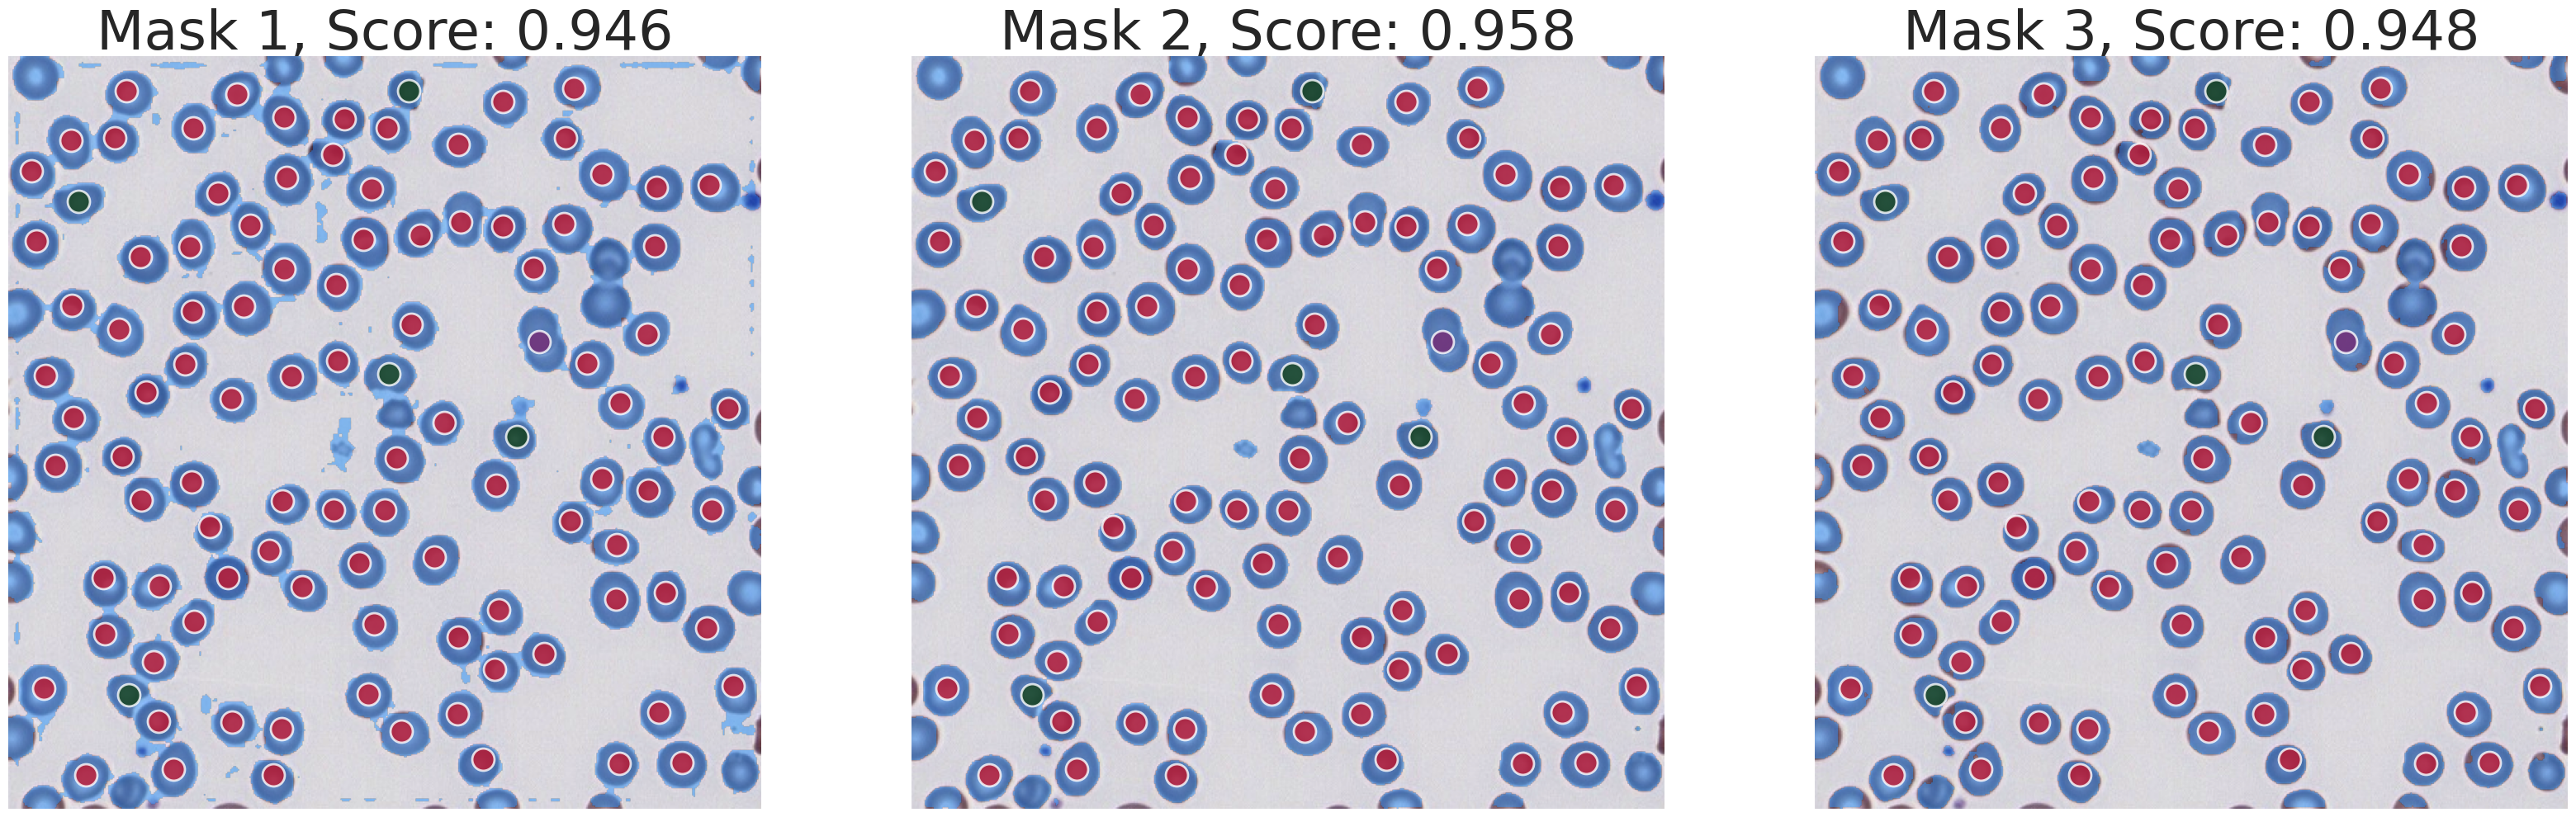

In [16]:
image, masks, scores, logits, input_point, input_label, donnees, image_record, out = afficheSegmentation('20_bif_x00000_00512_y00512_01024_00000002',model,strategy, nouvelleTaille=1024)


# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Detection avec les rectangles</div></b>


In [11]:
tailleImageFichier,tailleImage=512,1024 
image='../donnees/20_bif_x00000_00512_y00512_01024_00000002.png'
labels='../donnees/20_bif_x00000_00512_y00512_01024_00000002.parquet'
image=tf.stack([tf.image.resize(tf.image.decode_jpeg(tf.stack(tf.io.read_file(image))),(tailleImage,tailleImage))]) 
donnees=pd.read_parquet(labels)
donnees.loc[:,['x_min', 'y_min', 'x_max', 'y_max']] *= tailleImage/tailleImageFichier
donnees['x'] = donnees.x_min + (donnees.x_max - donnees.x_min)/2
donnees['y'] = donnees.y_min + (donnees.y_max - donnees.y_min)/2
input_boxes = np.array([list(ligne) for ligne in list(donnees[['x_min', 'y_min', 'x_max', 'y_max']].astype('float16').values)])
input_points = [list(ligne) for ligne in list(donnees[['x', 'y']].astype('float16').values)]
donnees.head()
image_record = {}
image_record["image"] = image
image_record["original_size"] = (image.shape[1], image.shape[2])
# image_record["point_coords"] = tf.stack([donnees[['x', 'y']].astype('float32').values])[:2]
image_record["point_labels"] = tf.stack([donnees['classe'].astype('float32').values])[:2]
image_record["boxes"] = tf.stack(donnees[['x_min', 'y_min', 'x_max', 'y_max']].astype('float32').values.reshape((donnees.shape[0],1,2,2)))
input_point, input_label = donnees[['x', 'y']].astype('float32').values,donnees['classe'].astype('float32').values

with strategy.scope():
    out = model.predict(image_record, multimask_output=False, batch_size=1)

masks = out["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)

105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step


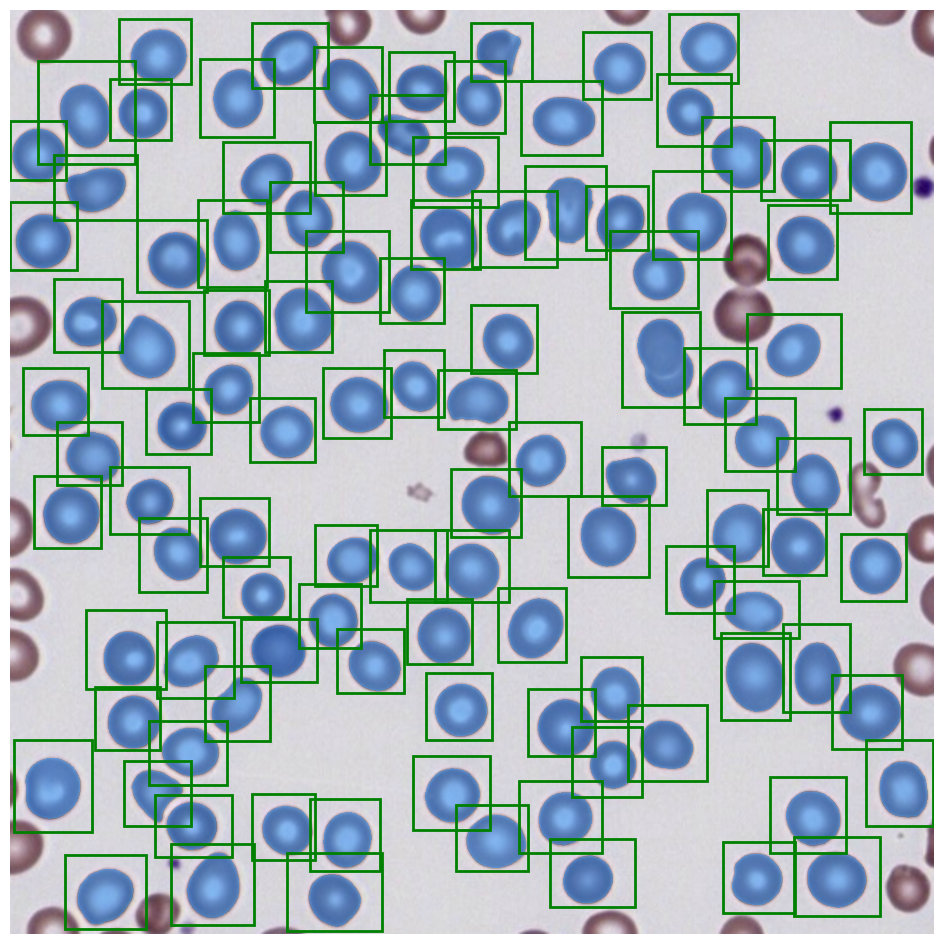

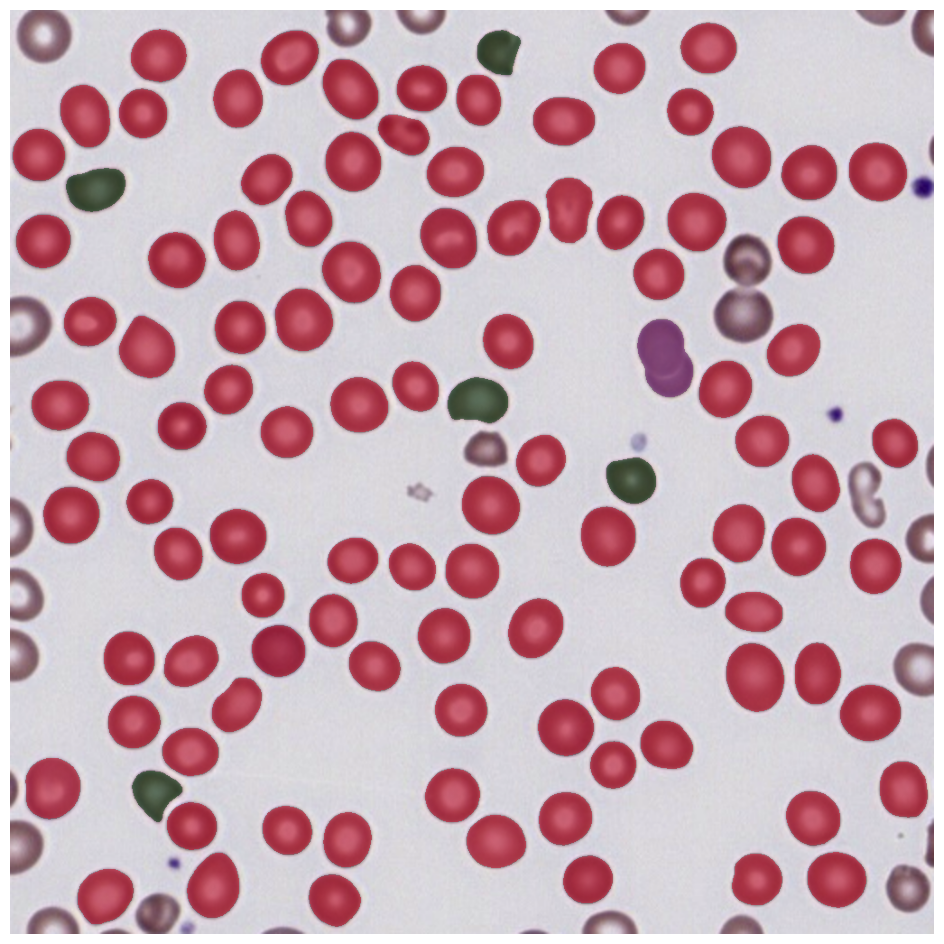

In [12]:
tailleGraph = 12
plt.figure(figsize=(tailleGraph,tailleGraph))
plt.imshow(image.numpy()[0].astype('uint8'))
for mask in masks:
    show_mask(mask, plt.gca(), random_color=False)
    
for box in image_record["boxes"].numpy().reshape((donnees.shape[0],4)):
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

plt.figure(figsize=(tailleGraph,tailleGraph))
plt.imshow(image.numpy()[0].astype('uint8'))
for mask,box,label in zip(masks,
                image_record["boxes"].numpy().reshape((donnees.shape[0],4)),
                image_record["point_labels"].numpy().astype('int16').ravel()) :

    show_mask_class(mask, plt.gca(), label,0.6)

plt.axis('off')
plt.show()


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Affichage des masks</div></b>


In [13]:
masks = out["masks"]
masks = ops.cast(masks > 0.0, dtype="float32")
masks = ops.convert_to_numpy(masks)
m = masks.reshape(105,tailleImage,tailleImage,1)
img = np.zeros((tailleImage,tailleImage,1)).astype('uint8')

In [14]:
for i,l in zip(m.astype('uint8'),donnees.classe.values) : img = cv2.bitwise_or(img, i*l)

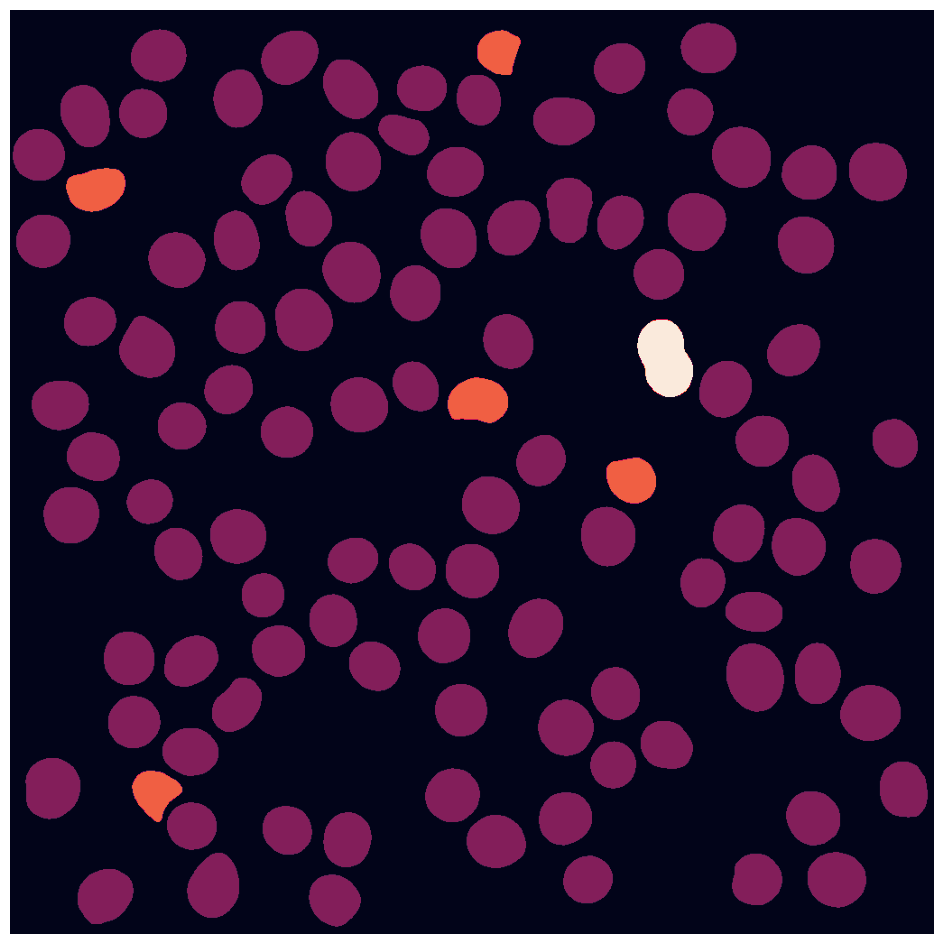

In [15]:
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()